# Perturbed Uniform Distributions

In [1]:
from jax import random
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
from matplotlib import pyplot as plt
import pickle
from pathlib import Path
Path("results").mkdir(exist_ok=True)
%load_ext autoreload
%autoreload 2

In [2]:
from dpkernel import dpmmd, dphsic
from dpkernelU import dpmmd_U, dphsic_U
from tot import tot_mmd, tot_hsic
from sarrm import sarrm_mmd, sarrm_hsic, compute_sarrm_optimal_k_p_alpha0
from me import me
from sampler_perturbations import sampler_perturb_2ST, sampler_perturb_IndT

In [3]:
# define all tests to take as inputs: key, X, Y, epsilon

# dpmmd is already of the form dpmmd(key, X, Y, epsilon)
# dphsic is already of the form dphsic(key, X, Y, epsilon)

# since we use B = 2000
def dpmmd_naive(key, X, Y, epsilon): 
    return dpmmd(key, X, Y, epsilon / 2000 * 2)
def dphsic_naive(key, X, Y, epsilon): 
    return dphsic(key, X, Y, epsilon / 2000 * 2)

def dpmmd_U_lower(key, X, Y, epsilon): 
    return dpmmd_U(key, X, Y, epsilon, bound_sensitivity='lower')
def dphsic_U_lower(key, X, Y, epsilon): 
    return dphsic_U(key, X, Y, epsilon, bound_sensitivity='lower')

def me_mmd(placeholder, X, Y, epsilon): 
    return jnp.array(me(X, Y, epsilon))

def sarrm__mmd(key, X, Y, epsilon): 
    return sarrm_mmd(key, X, Y, *sarrm_dictionary[round(float(epsilon), 5)])
def sarrm__hsic(key, X, Y, epsilon): 
    return sarrm_hsic(key, X, Y, *sarrm_dictionary[round(float(epsilon), 5)])

# the tot parameters S and alpha0 have been chosen empirically to maximize power

def tot__mmd(key, X, Y, epsilon): 
    assert X.shape[0] == Y.shape[0]
    n = X.shape[0]
    alpha = 0.05
    return tot_mmd(
        key=key, 
        X=X, 
        Y=Y, 
        epsilon=epsilon, 
        S=round(float(jnp.sqrt(n))), 
        alpha0=5 * alpha,
    )

def tot__hsic(key, X, Y, epsilon): 
    assert X.shape[0] == Y.shape[0]
    n = X.shape[0]
    alpha = 0.05
    return tot_hsic(
        key=key, 
        X=X, 
        Y=Y, 
        epsilon=epsilon, 
        S=round(float(jnp.sqrt(n))), 
        alpha0=5 * alpha,
    )

In [12]:
# Either:
# [1] Create dictionary of parameters for the SARRM test
# Or:
# [2] Load the precomputed dictionary of parameters for the SARRM test

In [ ]:
# [1] Create dictionary of parameters for the SARRM test
sarrm_dictionary = {}
alpha = 0.05
n = 3000
epsilons = jnp.concatenate(
    (
        jnp.linspace(1 / n, 10 / jnp.sqrt(n), 6),
        jnp.linspace(10 / jnp.sqrt(n), 1, 6),
        jnp.linspace(1, jnp.sqrt(n), 6),
        jnp.linspace(1 / jnp.sqrt(n), jnp.sqrt(n), 6),
        jnp.array([jnp.sqrt(n) / 10, 1, jnp.sqrt(n) / 10]),
        jnp.array([10 / jnp.sqrt(m) for m in (1000, 2000, 3000, 4000, 5000)]),
        jnp.array([jnp.sqrt(m) / 10 for m in (1000, 2000, 3000, 4000, 5000)]),
        jnp.linspace(1, jnp.sqrt(5000), 6),
        jnp.array([jnp.sqrt(m) for m in (1000, 2000, 3000, 4000, 5000)]),
    )
)

for epsilon in tqdm(epsilons):
    k, p, alpha0 = compute_sarrm_optimal_k_p_alpha0(alpha, epsilon, verbose=False)
    sarrm_dictionary[round(float(epsilon), 5)] = (k, p, alpha0)
    
sarrm_dictionary[54.77225] = sarrm_dictionary[54.77226]
sarrm_dictionary[33.26336] = sarrm_dictionary[33.26335]

In [7]:
# [2] Load the precomputed dictionary of parameters for the SARRM test
with open('results/sarrm_dictionary_perturbations.pickle', 'rb') as handle:
    sarrm_dictionary = pickle.load(handle)

# Two-Sample Testing

## Vary privacy

### Power: Vary privacy (high privacy regime)

In [ ]:
# parameters
repetitions = 200
m = n = 3000
epsilons = jnp.linspace(1 / n, 10 / jnp.sqrt(n), 6)
num_perturbations = 1
d = 1
scale = 0.2
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd, me_mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# run experiment
key = random.PRNGKey(42)
key, subkey = random.split(key)
X_all, Y_all = sampler_perturb_2ST(
    key=subkey,
    m=m,
    n=n,
    d=d,
    num_random=repetitions,
    num_perturbations=num_perturbations,
    scale=scale,
)
outputs = jnp.zeros((len(tests), len(epsilons), repetitions))
for i in range(repetitions):
    X = X_all[i] * 4
    Y = Y_all[i] * 4
    for s in range(len(epsilons)):
        epsilon = epsilons[s]    
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_mmd_power_vary_privacy_high.npy", power)
jnp.save("results/uniform_mmd_power_vary_privacy_high_x_axis.npy", epsilons)

dpmmd 
 [0.065      0.42999998 0.835      0.93       0.97499996 0.98499995] 

dpmmd_naive 
 [0.065 0.035 0.04  0.035 0.05  0.06 ] 

dpmmd_U 
 [0.065 0.035 0.05  0.045 0.075 0.07 ] 

tot_mmd 
 [0.05       0.065      0.065      0.08       0.09999999 0.12      ] 

sarrm_mmd 
 [-1.     0.07   0.045  0.04   0.045  0.07 ] 

me_mmd 
 [0.015 0.01  0.01  0.015 0.02  0.015] 



Text(0.5, 1.0, 'Two-sample testing \n privacy 1/n to 10/sqrt(n)\n Sample size 3000\n Amplitude 0.2')

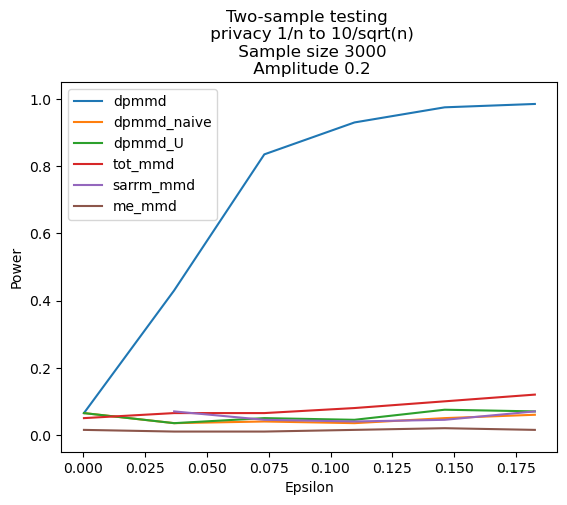

In [23]:
# load results
power = jnp.load("results/uniform_mmd_power_vary_privacy_high.npy")
x_axis = jnp.load("results/uniform_mmd_power_vary_privacy_high_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Epsilon')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Two-sample testing \n privacy 1/n to 10/sqrt(n)'
    '\n Sample size 3000'
    '\n Amplitude 0.2'
)

### Power: Vary privacy (med privacy regime)

In [ ]:
# parameters
repetitions = 200
m = n = 3000
epsilons = jnp.linspace(10 / jnp.sqrt(n), 1, 6)
num_perturbations = 1
d = 1
scale = 0.15
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd, me_mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# run experiment
key = random.PRNGKey(42)
key, subkey = random.split(key)
X_all, Y_all = sampler_perturb_2ST(
    key=subkey,
    m=m,
    n=n,
    d=d,
    num_random=repetitions,
    num_perturbations=num_perturbations,
    scale=scale,
)
outputs = jnp.zeros((len(tests), len(epsilons), repetitions))
for i in range(repetitions):
    X = X_all[i] * 4
    Y = Y_all[i] * 4
    for s in range(len(epsilons)):
        epsilon = epsilons[s]    
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_mmd_power_vary_privacy_mid.npy", power)
jnp.save("results/uniform_mmd_power_vary_privacy_mid_x_axis.npy", epsilons)

dpmmd 
 [0.9        0.92499995 0.955      0.95       0.95       0.95      ] 

dpmmd_naive 
 [0.065 0.035 0.04  0.035 0.05  0.06 ] 

dpmmd_U 
 [0.07  0.055 0.08  0.09  0.13  0.16 ] 

tot_mmd 
 [0.08       0.125      0.175      0.16       0.16       0.17999999] 

sarrm_mmd 
 [0.05  0.05  0.09  0.13  0.145 0.305] 

me_mmd 
 [0.025 0.015 0.01  0.01  0.    0.01 ] 



Text(0.5, 1.0, 'Two-sample testing \n privacy 10/sqrt(n) to 1\n Sample size 3000\n Amplitude 0.15')

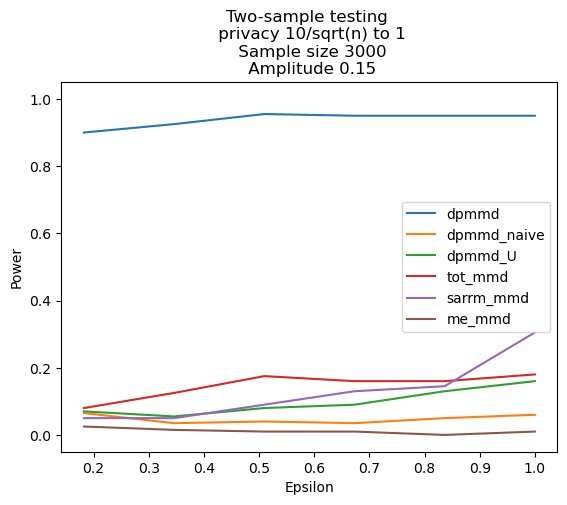

In [26]:
# load results
power = jnp.load("results/uniform_mmd_power_vary_privacy_mid.npy")
x_axis = jnp.load("results/uniform_mmd_power_vary_privacy_mid_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Epsilon')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Two-sample testing \n privacy 10/sqrt(n) to 1'
    '\n Sample size 3000'
    '\n Amplitude 0.15'
)

### Power: Vary privacy (low privacy regime)

In [ ]:
# parameters
repetitions = 200
m = n = 3000
epsilons = jnp.linspace(1, jnp.sqrt(n), 6)
num_perturbations = 1
d = 1
scale = 0.1
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd, me_mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# run experiment
key = random.PRNGKey(42)
key, subkey = random.split(key)
X_all, Y_all = sampler_perturb_2ST(
    key=subkey,
    m=m,
    n=n,
    d=d,
    num_random=repetitions,
    num_perturbations=num_perturbations,
    scale=scale,
)
outputs = jnp.zeros((len(tests), len(epsilons), repetitions))
for i in range(repetitions):
    X = X_all[i] * 4
    Y = Y_all[i] * 4
    for s in range(len(epsilons)):
        epsilon = epsilons[s]    
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_mmd_power_vary_privacy_low.npy", power)
jnp.save("results/uniform_mmd_power_vary_privacy_low_x_axis.npy", epsilons)

dpmmd 
 [0.66499996 0.65999997 0.65999997 0.65999997 0.65999997 0.66499996] 

dpmmd_naive 
 [0.07  0.05  0.075 0.09  0.125 0.17 ] 

dpmmd_U 
 [0.085      0.58       0.645      0.655      0.655      0.66499996] 

tot_mmd 
 [0.105      0.09999999 0.105      0.13499999 0.12       0.12      ] 

sarrm_mmd 
 [0.125 0.26  0.265 0.26  0.255 0.255] 

me_mmd 
 [0.015 0.01  0.01  0.005 0.015 0.015] 



Text(0.5, 1.0, 'Two-sample testing\n Low privacy 1 to sqrt(n)\n Sample size 3000\n Amplitude 0.1')

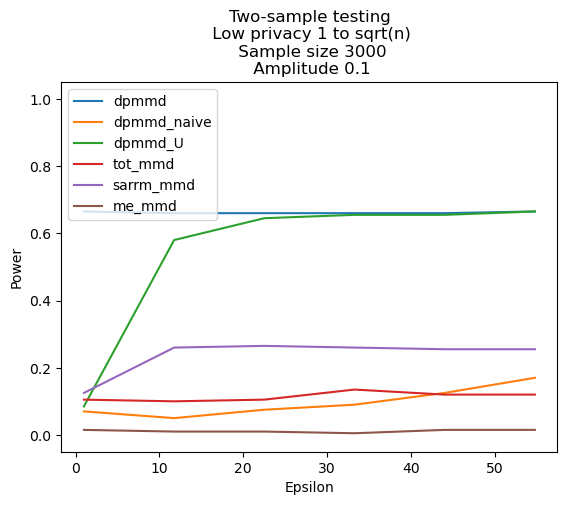

In [29]:
# load results
power = jnp.load("results/uniform_mmd_power_vary_privacy_low.npy")
x_axis = jnp.load("results/uniform_mmd_power_vary_privacy_low_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Epsilon')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Two-sample testing'
    '\n Low privacy 1 to sqrt(n)'
    '\n Sample size 3000'
    '\n Amplitude 0.1'
)

### Power Appendix: Vary privacy

In [ ]:
# parameters
repetitions = 200
m = n = 3000
scalar = 10
epsilons = jnp.linspace(1, jnp.sqrt(n), 6)
num_perturbations = 1
d = 1
scale = 1
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd, me_mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# run experiment
key = random.PRNGKey(42)
key, subkey = random.split(key)
X_all, Y_all = sampler_perturb_2ST(
    key=subkey,
    m=m,
    n=n,
    d=d,
    num_random=repetitions,
    num_perturbations=num_perturbations,
    scale=scale,
)
outputs = jnp.zeros((len(tests), len(epsilons), repetitions))
for i in range(repetitions):
    X = X_all[i] * 4
    Y = Y_all[i] * 4
    for s in range(len(epsilons)):
        epsilon = epsilons[s]    
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_mmd_power_vary_privacy_appendix.npy", power)
jnp.save("results/uniform_mmd_power_vary_privacy_appendix_x_axis.npy", epsilons)

dpmmd 
 [1. 1. 1. 1. 1. 1.] 

dpmmd_naive 
 [0.08       0.92499995 1.         1.         1.         1.        ] 

dpmmd_U 
 [1. 1. 1. 1. 1. 1.] 

tot_mmd 
 [1. 1. 1. 1. 1. 1.] 

sarrm_mmd 
 [0.965 1.    1.    1.    1.    1.   ] 

me_mmd 
 [0.         0.505      0.91999996 0.965      0.97999996 0.97999996] 



Text(0.5, 1.0, 'Two-sample testing\n Low privacy 1 to n\n Sample size 3000\n Amplitude 1')

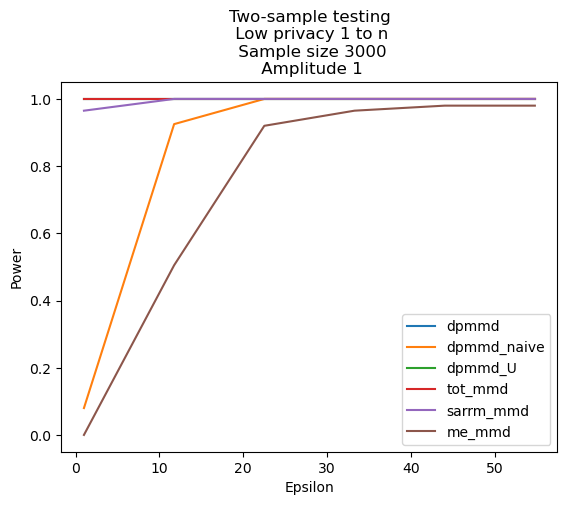

In [32]:
# load results
power = jnp.load("results/uniform_mmd_power_vary_privacy_appendix.npy")
x_axis = jnp.load("results/uniform_mmd_power_vary_privacy_appendix_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Epsilon')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Two-sample testing'
    '\n Low privacy 1 to n'
    '\n Sample size 3000'
    '\n Amplitude 1'
)

### Level: Vary privacy

In [ ]:
# parameters
repetitions = 200
m = n = 3000
epsilons = jnp.linspace(1 / jnp.sqrt(n), jnp.sqrt(n), 6)
num_perturbations = 1
d = 1
scale = 0
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd, me_mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# run experiment
key = random.PRNGKey(42)
key, subkey = random.split(key)
X_all, Y_all = sampler_perturb_2ST(
    key=subkey,
    m=m,
    n=n,
    d=d,
    num_random=repetitions,
    num_perturbations=num_perturbations,
    scale=scale,
)
outputs = jnp.zeros((len(tests), len(epsilons), repetitions))
for i in range(repetitions):
    X = X_all[i] * 4
    Y = Y_all[i] * 4
    for s in range(len(epsilons)):
        epsilon = epsilons[s]    
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_mmd_level_vary_privacy.npy", power)
jnp.save("results/uniform_mmd_level_vary_privacy_x_axis.npy", epsilons)

dpmmd 
 [0.075 0.065 0.07  0.08  0.08  0.07 ] 

dpmmd_naive 
 [0.065 0.035 0.045 0.03  0.055 0.06 ] 

dpmmd_U 
 [0.065 0.06  0.06  0.08  0.075 0.07 ] 

tot_mmd 
 [0.05  0.045 0.04  0.035 0.045 0.05 ] 

sarrm_mmd 
 [0.06  0.055 0.055 0.05  0.04  0.045] 

me_mmd 
 [0.015 0.005 0.025 0.01  0.015 0.01 ] 



Text(0.5, 1.0, 'Two-sample testing\n Privacy 1/sqrt(n) to sqrt(n)\n Sample size 3000')

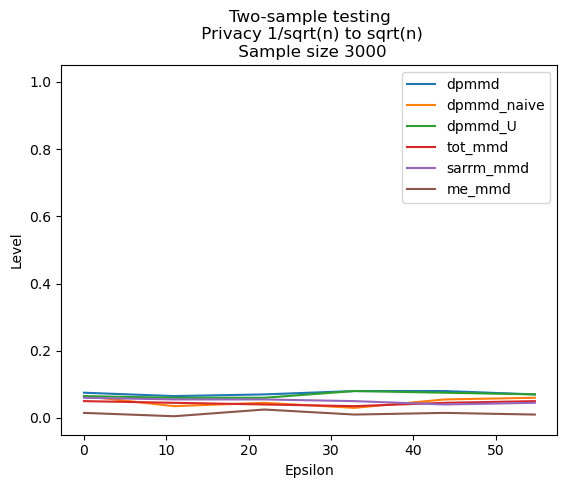

In [37]:
# load results
power = jnp.load("results/uniform_mmd_level_vary_privacy.npy")
x_axis = jnp.load("results/uniform_mmd_level_vary_privacy_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Epsilon')
plt.ylabel('Level')
plt.ylim(-0.05, 1.05)
plt.title(
    'Two-sample testing'
    '\n Privacy 1/sqrt(n) to sqrt(n)'
    '\n Sample size 3000'
)

## Vary sample size

### Power: Vary sample size (high privacy)

In [ ]:
# parameters
repetitions = 200
sample_sizes = (1000, 2000, 3000, 4000, 5000)
num_perturbations = 1
d = 1
scale = 0.1
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd, me_mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# run experiment
key = random.PRNGKey(43)
outputs = jnp.zeros((len(tests), len(sample_sizes), repetitions))
for s in range(len(sample_sizes)):
    m = n = sample_sizes[s]
    epsilon = 10 / jnp.sqrt(n)
    key, subkey = random.split(key)
    X_all, Y_all = sampler_perturb_2ST(
        key=subkey,
        m=m,
        n=n,
        d=d,
        num_random=repetitions,
        num_perturbations=num_perturbations,
        scale=scale,
    )
    for i in range(repetitions):
        X = X_all[i] * 4
        Y = Y_all[i] * 4
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_mmd_power_vary_n_high.npy", power)
jnp.save("results/uniform_mmd_power_vary_n_high_x_axis.npy", sample_sizes)

dpmmd 
 [0.19999999 0.32       0.575      0.68       0.79999995] 

dpmmd_naive 
 [0.02  0.03  0.04  0.045 0.06 ] 

dpmmd_U 
 [0.02  0.03  0.05  0.045 0.07 ] 

tot_mmd 
 [0.06 0.06 0.06 0.05 0.04] 

sarrm_mmd 
 [0.06  0.075 0.03  0.05  0.055] 

me_mmd 
 [0.005 0.005 0.015 0.015 0.01 ] 



Text(0.5, 1.0, 'Two-sample testing\n High privacy 10/sqrt(n)\n Amplitude 0.1')

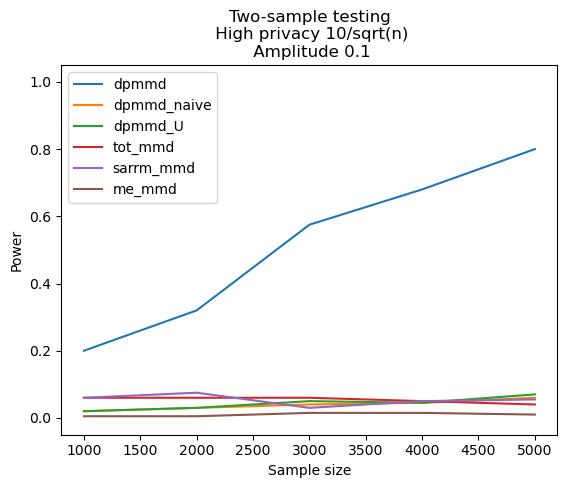

In [41]:
# load results
power = jnp.load("results/uniform_mmd_power_vary_n_high.npy")
x_axis = jnp.load("results/uniform_mmd_power_vary_n_high_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Sample size')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(    
    'Two-sample testing' 
    '\n High privacy 10/sqrt(n)' 
    '\n Amplitude 0.1'
)

### Power: Vary sample size (mid privacy)

In [ ]:
# parameters
repetitions = 200
sample_sizes = (1000, 2000, 3000, 4000, 5000)
num_perturbations = 1
d = 1
scale = 0.1
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd, me_mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# run experiment
key = random.PRNGKey(43)
outputs = jnp.zeros((len(tests), len(sample_sizes), repetitions))
for s in range(len(sample_sizes)):
    m = n = sample_sizes[s]
    epsilon = 1
    key, subkey = random.split(key)
    X_all, Y_all = sampler_perturb_2ST(
        key=subkey,
        m=m,
        n=n,
        d=d,
        num_random=repetitions,
        num_perturbations=num_perturbations,
        scale=scale,
    )
    for i in range(repetitions):
        X = X_all[i] * 4
        Y = Y_all[i] * 4
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_mmd_power_vary_n_mid.npy", power)
jnp.save("results/uniform_mmd_power_vary_n_mid_x_axis.npy", sample_sizes)

dpmmd 
 [0.25       0.42499998 0.675      0.77       0.875     ] 

dpmmd_naive 
 [0.02  0.03  0.045 0.045 0.065] 

dpmmd_U 
 [0.03  0.035 0.08  0.095 0.16 ] 

tot_mmd 
 [0.065      0.055      0.105      0.09999999 0.12      ] 

sarrm_mmd 
 [0.11  0.07  0.105 0.105 0.195] 

me_mmd 
 [0.01  0.005 0.005 0.005 0.005] 



Text(0.5, 1.0, 'Two-sample testing\n Mid privacy 1\n Amplitude 0.1')

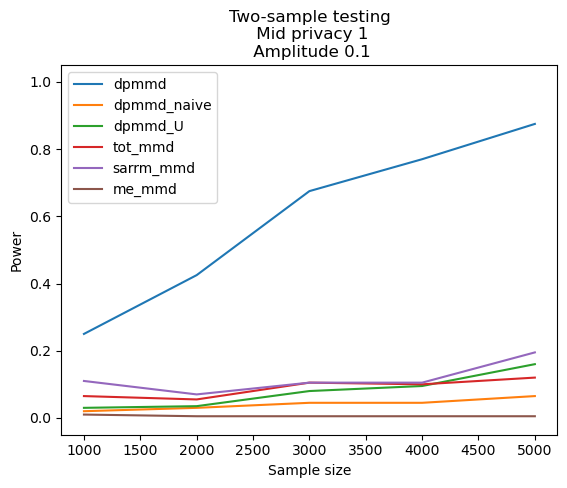

In [52]:
# load results
power = jnp.load("results/uniform_mmd_power_vary_n_mid.npy")
x_axis = jnp.load("results/uniform_mmd_power_vary_n_mid_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Sample size')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(    
    'Two-sample testing' 
    '\n Mid privacy 1' 
    '\n Amplitude 0.1'
)

### Power: Vary sample size (low privacy)

In [ ]:
# parameters
repetitions = 200
sample_sizes = (1000, 2000, 3000, 4000, 5000)
num_perturbations = 1
d = 1
scale = 0.1
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd, me_mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# run experiment
key = random.PRNGKey(43)
outputs = jnp.zeros((len(tests), len(sample_sizes), repetitions))
for s in range(len(sample_sizes)):
    m = n = sample_sizes[s]
    epsilon = jnp.sqrt(n) / 10
    key, subkey = random.split(key)
    X_all, Y_all = sampler_perturb_2ST(
        key=subkey,
        m=m,
        n=n,
        d=d,
        num_random=repetitions,
        num_perturbations=num_perturbations,
        scale=scale,
    )
    for i in range(repetitions):
        X = X_all[i] * 4
        Y = Y_all[i] * 4
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_mmd_power_vary_n_low.npy", power)
jnp.save("results/uniform_mmd_power_vary_n_low_x_axis.npy", sample_sizes)

dpmmd 
 [0.26       0.45499998 0.68       0.77       0.875     ] 

dpmmd_naive 
 [0.02  0.03  0.05  0.05  0.075] 

dpmmd_U 
 [0.09       0.16       0.465      0.59499997 0.78      ] 

tot_mmd 
 [0.07  0.04  0.105 0.12  0.125] 

sarrm_mmd 
 [0.13  0.19  0.29  0.445 0.56 ] 

me_mmd 
 [0.01  0.005 0.005 0.005 0.005] 



Text(0.5, 1.0, 'Two-sample testing\n Low privacy sqrt(n)/10\n Amplitude 0.1')

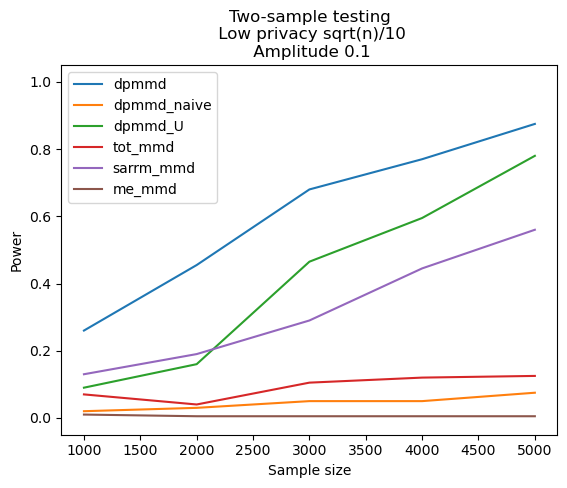

In [53]:
# load results
power = jnp.load("results/uniform_mmd_power_vary_n_low.npy")
x_axis = jnp.load("results/uniform_mmd_power_vary_n_low_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Sample size')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(    
    'Two-sample testing' 
    '\n Low privacy sqrt(n)/10' 
    '\n Amplitude 0.1'
)

### Power Appendix: Vary sample size

In [ ]:
# parameters
repetitions = 200
sample_sizes = (1000, 2000, 3000, 4000, 5000)
num_perturbations = 1
d = 1
scale = 1
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd, me_mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# run experiment
key = random.PRNGKey(43)
outputs = jnp.zeros((len(tests), len(sample_sizes), repetitions))
for s in range(len(sample_sizes)):
    m = n = sample_sizes[s]
    epsilon = jnp.sqrt(n) / 10
    key, subkey = random.split(key)
    X_all, Y_all = sampler_perturb_2ST(
        key=subkey,
        m=m,
        n=n,
        d=d,
        num_random=repetitions,
        num_perturbations=num_perturbations,
        scale=scale,
    )
    for i in range(repetitions):
        X = X_all[i] * 4
        Y = Y_all[i] * 4
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_mmd_power_vary_n_appendix.npy", power)
jnp.save("results/uniform_mmd_power_vary_n_appendix_x_axis.npy", sample_sizes)

dpmmd 
 [1. 1. 1. 1. 1.] 

dpmmd_naive 
 [0.04       0.09999999 0.385      0.78       0.95      ] 

dpmmd_U 
 [1. 1. 1. 1. 1.] 

tot_mmd 
 [1. 1. 1. 1. 1.] 

sarrm_mmd 
 [1. 1. 1. 1. 1.] 

me_mmd 
 [0.005      0.         0.005      0.73499995 0.935     ] 



Text(0.5, 1.0, 'Two-sample testing\n Low privacy sqrt(n) / 10\n Amplitude 1')

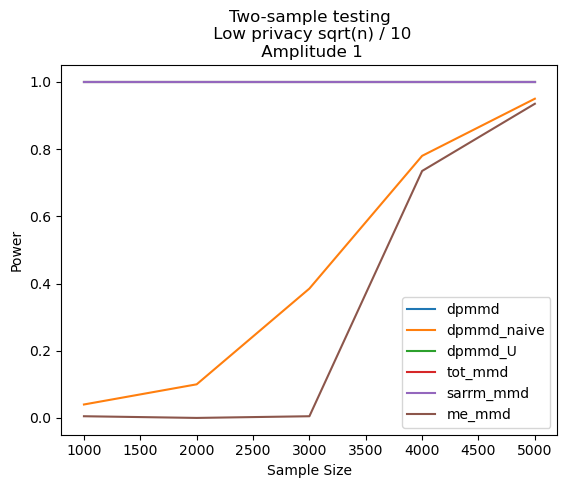

In [56]:
# load results
power = jnp.load("results/uniform_mmd_power_vary_n_appendix.npy")
x_axis = jnp.load("results/uniform_mmd_power_vary_n_appendix_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Sample Size')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Two-sample testing' 
    '\n Low privacy sqrt(n) / 10' 
    '\n Amplitude 1'
)

### Level: Vary sample size

In [ ]:
# parameters
repetitions = 200
sample_sizes = (1000, 2000, 3000, 4000, 5000)
num_perturbations = 1
d = 100
scale = 0
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd, me_mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# run experiment
key = random.PRNGKey(43)
outputs = jnp.zeros((len(tests), len(sample_sizes), repetitions))
for s in range(len(sample_sizes)):
    m = n = sample_sizes[s]
    epsilon = 10 / jnp.sqrt(n)
    key, subkey = random.split(key)
    X_all, Y_all = sampler_perturb_2ST(
        key=subkey,
        m=m,
        n=n,
        d=d,
        num_random=repetitions,
        num_perturbations=num_perturbations,
        scale=scale,
    )
    for i in range(repetitions):
        X = X_all[i] * 4
        Y = Y_all[i] * 4
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_mmd_level_vary_n.npy", power)
jnp.save("results/uniform_mmd_level_vary_n_x_axis.npy", sample_sizes)

dpmmd 
 [0.02  0.03  0.04  0.045 0.065] 

dpmmd_naive 
 [0.02  0.03  0.04  0.045 0.06 ] 

dpmmd_U 
 [0.02  0.03  0.04  0.045 0.06 ] 

tot_mmd 
 [0.055 0.06  0.055 0.04  0.045] 

sarrm_mmd 
 [0.05  0.075 0.03  0.035 0.05 ] 

me_mmd 
 [0.23999999 0.39499998 0.51999998 0.57499999 0.66499996] 



Text(0.5, 1.0, 'Two-sample testing\n High privacy 10/sqrt(n)\n Dimension 100')

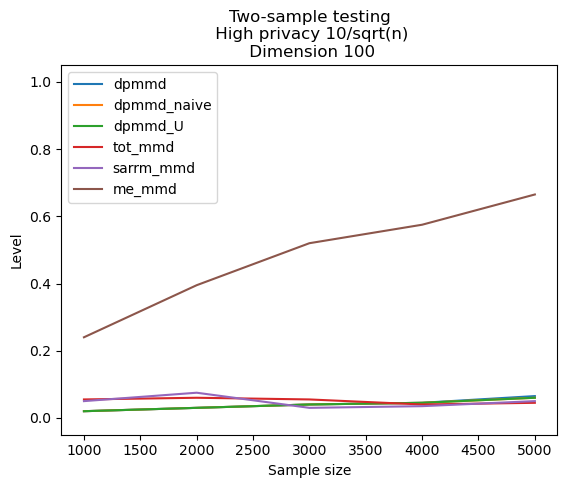

In [66]:
# load results
power = jnp.load("results/uniform_mmd_level_vary_n.npy")
x_axis = jnp.load("results/uniform_mmd_level_vary_n_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Sample size')
plt.ylabel('Level')
plt.ylim(-0.05, 1.05)
plt.title(
    'Two-sample testing' 
    '\n High privacy 10/sqrt(n)' 
    '\n Dimension 100'
)

## Vary dimension

### Power: Vary dimension (high privacy)

In [ ]:
# parameters
repetitions = 200
m = n = 3000
epsilon = 10 / jnp.sqrt(n)
dimensions = (1, 3, 5, 7, 9)
num_perturbations = 1
scale = 0.2
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd, me_mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# run experiment
key = random.PRNGKey(43)
outputs = jnp.zeros((len(tests), len(dimensions), repetitions))
for s in range(len(dimensions)):
    d = dimensions[s]
    key, subkey = random.split(key)
    X_all, Y_all = sampler_perturb_2ST(
        key=subkey,
        m=m,
        n=n,
        d=d,
        num_random=repetitions,
        num_perturbations=num_perturbations,
        scale=scale,
    )
    for i in range(repetitions):
        X = X_all[i] * 4
        Y = Y_all[i] * 4
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_mmd_power_vary_d_high.npy", power)
jnp.save("results/uniform_mmd_power_vary_d_high_x_axis.npy", dimensions)

dpmmd 
 [0.975 0.755 0.415 0.29  0.16 ] 

dpmmd_naive 
 [0.04  0.1   0.055 0.04  0.045] 

dpmmd_U 
 [0.05  0.11  0.055 0.04  0.045] 

tot_mmd 
 [0.105 0.065 0.035 0.05  0.085] 

sarrm_mmd 
 [0.06 0.05 0.08 0.07 0.1 ] 

me_mmd 
 [0.005 0.045 0.07  0.075 0.045] 



Text(0.5, 1.0, 'Two-sample testing\n High privacy 10/sqrt(n)\n Amplitude 0.2')

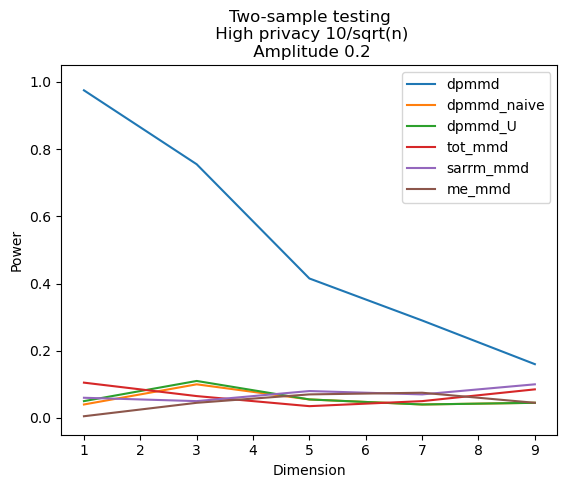

In [69]:
# load results
power = jnp.load("results/uniform_mmd_power_vary_d_high.npy")
x_axis = jnp.load("results/uniform_mmd_power_vary_d_high_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Dimension')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(    
    'Two-sample testing' 
    '\n High privacy 10/sqrt(n)' 
    '\n Amplitude 0.2'
)

### Power: Vary dimension (mid privacy)

In [ ]:
# parameters
repetitions = 200
m = n = 3000
epsilon = 1
dimensions = (1, 3, 5, 7, 9)
num_perturbations = 1
scale = 0.2
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd, me_mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# run experiment
key = random.PRNGKey(43)
outputs = jnp.zeros((len(tests), len(dimensions), repetitions))
for s in range(len(dimensions)):
    d = dimensions[s]
    key, subkey = random.split(key)
    X_all, Y_all = sampler_perturb_2ST(
        key=subkey,
        m=m,
        n=n,
        d=d,
        num_random=repetitions,
        num_perturbations=num_perturbations,
        scale=scale,
    )
    for i in range(repetitions):
        X = X_all[i] * 4
        Y = Y_all[i] * 4
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_mmd_power_vary_d_mid.npy", power)
jnp.save("results/uniform_mmd_power_vary_d_mid_x_axis.npy", dimensions)

dpmmd 
 [0.995      0.96999997 0.9        0.78999996 0.78      ] 

dpmmd_naive 
 [0.02  0.03  0.045 0.045 0.06 ] 

dpmmd_U 
 [0.32  0.04  0.065 0.055 0.075] 

tot_mmd 
 [0.325      0.175      0.11499999 0.105      0.105     ] 

sarrm_mmd 
 [0.49499997 0.24       0.12       0.155      0.105     ] 

me_mmd 
 [0.01  0.045 0.07  0.08  0.045] 



Text(0.5, 1.0, 'Two-sample testing\n Mid privacy 1\n Amplitude 0.2')

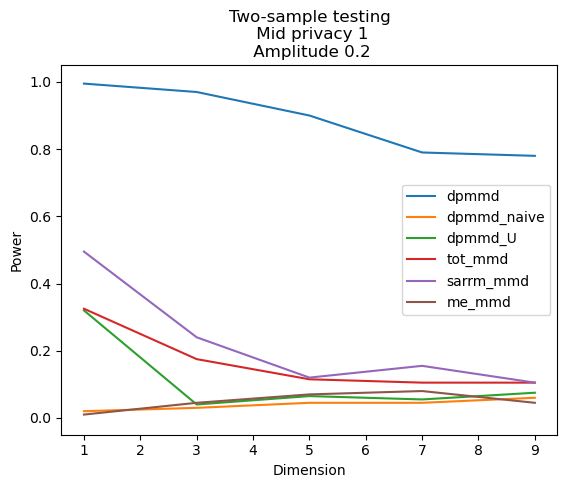

In [72]:
# load results
power = jnp.load("results/uniform_mmd_power_vary_d_mid.npy")
x_axis = jnp.load("results/uniform_mmd_power_vary_d_mid_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Dimension')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(    
    'Two-sample testing' 
    '\n Mid privacy 1' 
    '\n Amplitude 0.2'
)

### Power: Vary dimension (low privacy)

In [ ]:
# parameters
repetitions = 200
m = n = 3000
epsilon = jnp.sqrt(n) / 10
dimensions = (1, 3, 5, 7, 9)
num_perturbations = 1
scale = 0.2
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd, me_mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# run experiment
key = random.PRNGKey(43)
outputs = jnp.zeros((len(tests), len(dimensions), repetitions))
for s in range(len(dimensions)):
    d = dimensions[s]
    key, subkey = random.split(key)
    X_all, Y_all = sampler_perturb_2ST(
        key=subkey,
        m=m,
        n=n,
        d=d,
        num_random=repetitions,
        num_perturbations=num_perturbations,
        scale=scale,
    )
    for i in range(repetitions):
        X = X_all[i] * 4
        Y = Y_all[i] * 4
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_mmd_power_vary_d_low.npy", power)
jnp.save("results/uniform_mmd_power_vary_d_low_x_axis.npy", dimensions)

dpmmd 
 [0.995      0.96999997 0.91499996 0.835      0.825     ] 

dpmmd_naive 
 [0.04  0.03  0.05  0.045 0.065] 

dpmmd_U 
 [0.96       0.575      0.305      0.09999999 0.11499999] 

tot_mmd 
 [0.37       0.185      0.12       0.11499999 0.12      ] 

sarrm_mmd 
 [0.945      0.65999997 0.47       0.465      0.325     ] 

me_mmd 
 [0.005 0.045 0.07  0.075 0.045] 



Text(0.5, 1.0, 'Two-sample testing\n Low privacy sqrt(n)/10\n Amplitude 0.2')

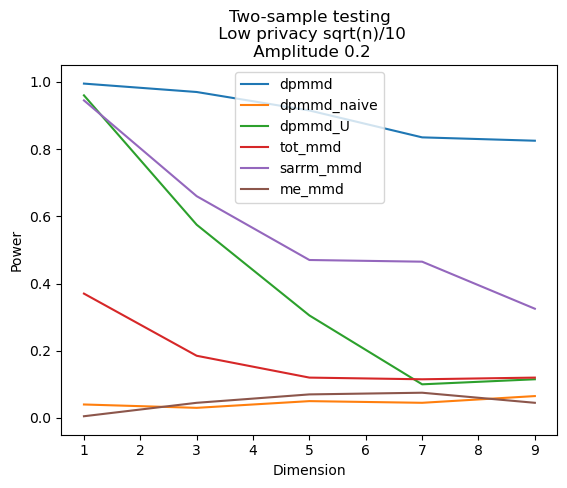

In [75]:
# load results
power = jnp.load("results/uniform_mmd_power_vary_d_low.npy")
x_axis = jnp.load("results/uniform_mmd_power_vary_d_low_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Dimension')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(    
    'Two-sample testing' 
    '\n Low privacy sqrt(n)/10' 
    '\n Amplitude 0.2'
)

### Power Appendix: Vary dimension

In [ ]:
# parameters
repetitions = 200
m = n = 5000
epsilon = jnp.sqrt(n) / 10
dimensions = (1, 3, 5, 7, 9)
num_perturbations = 1
scale = 1
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd, me_mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# run experiment
key = random.PRNGKey(43)
outputs = jnp.zeros((len(tests), len(dimensions), repetitions))
for s in range(len(dimensions)):
    d = dimensions[s]
    key, subkey = random.split(key)
    X_all, Y_all = sampler_perturb_2ST(
        key=subkey,
        m=m,
        n=n,
        d=d,
        num_random=repetitions,
        num_perturbations=num_perturbations,
        scale=scale,
    )
    for i in range(repetitions):
        X = X_all[i] * 4
        Y = Y_all[i] * 4
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_mmd_power_vary_d_appendix.npy", power)
jnp.save("results/uniform_mmd_power_vary_d_appendix_x_axis.npy", dimensions)

dpmmd 
 [1. 1. 1. 1. 1.] 

dpmmd_naive 
 [0.94       0.39499998 0.21499999 0.13499999 0.145     ] 

dpmmd_U 
 [1. 1. 1. 1. 1.] 

tot_mmd 
 [1. 1. 1. 1. 1.] 

sarrm_mmd 
 [1. 1. 1. 1. 1.] 

me_mmd 
 [0.955 0.325 0.01  0.    0.005] 



Text(0.5, 1.0, 'Two-sample testing\n Low privacy sqrt(n) / 10\n Sample size 5000\n Amplitude 1')

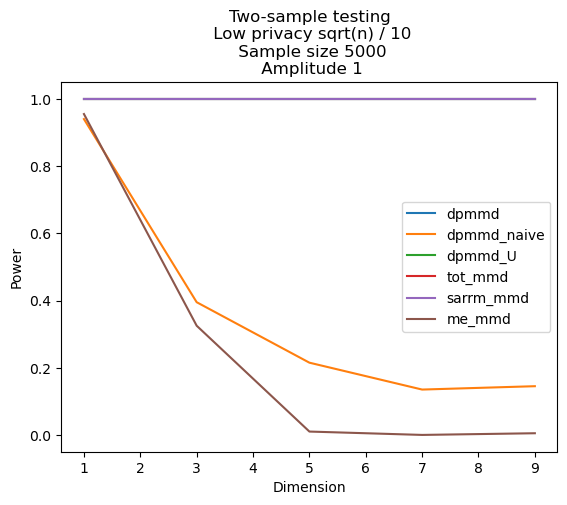

In [78]:
# load results
power = jnp.load("results/uniform_mmd_power_vary_d_appendix.npy")
x_axis = jnp.load("results/uniform_mmd_power_vary_d_appendix_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Dimension')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(    
    'Two-sample testing' 
    '\n Low privacy sqrt(n) / 10' 
    '\n Sample size 5000'
    '\n Amplitude 1'
)

### Level: Vary dimension

In [ ]:
# parameters
repetitions = 200
m = n = 3000
epsilon = jnp.sqrt(n) / 10
dimensions = (1, 50, 100, 150, 200)
num_perturbations = 1
scale = 0
tests = (dpmmd, dpmmd_naive, dpmmd_U_lower, tot__mmd, sarrm__mmd, me_mmd)
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# run experiment
key = random.PRNGKey(43)
outputs = jnp.zeros((len(tests), len(dimensions), repetitions))
for s in range(len(dimensions)):
    d = dimensions[s]
    key, subkey = random.split(key)
    X_all, Y_all = sampler_perturb_2ST(
        key=subkey,
        m=m,
        n=n,
        d=d,
        num_random=repetitions,
        num_perturbations=num_perturbations,
        scale=scale,
    )
    for i in range(repetitions):
        X = X_all[i] * 4
        Y = Y_all[i] * 4
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_mmd_level_vary_d.npy", power)
jnp.save("results/uniform_mmd_level_vary_d_x_axis.npy", dimensions)

dpmmd 
 [0.065 0.045 0.05  0.06  0.04 ] 

dpmmd_naive 
 [0.02  0.03  0.04  0.045 0.06 ] 

dpmmd_U 
 [0.045 0.03  0.04  0.045 0.06 ] 

tot_mmd 
 [0.05  0.055 0.04  0.065 0.07 ] 

sarrm_mmd 
 [0.06  0.03  0.07  0.03  0.045] 

me_mmd 
 [0.01       0.31       0.505      0.09999999 0.        ] 



Text(0.5, 1.0, 'Two-sample testing\n Low privacy sqrt(n) / 10\n Sample size 3000')

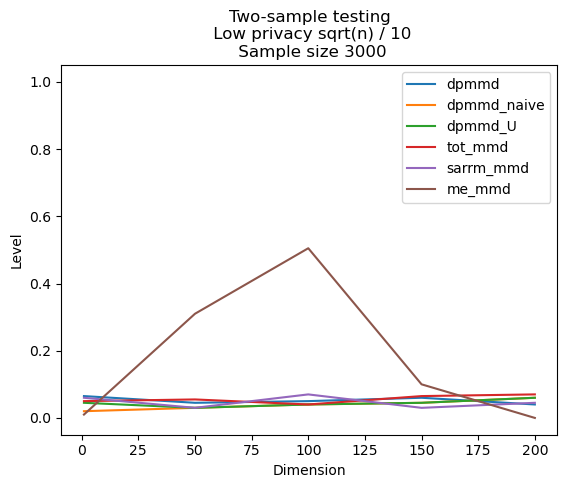

In [81]:
# load results
power = jnp.load("results/uniform_mmd_level_vary_d.npy")
x_axis = jnp.load("results/uniform_mmd_level_vary_d_x_axis.npy")
tests_labels = ('dpmmd', 'dpmmd_naive', 'dpmmd_U', 'tot_mmd', 'sarrm_mmd', 'me_mmd')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Dimension')
plt.ylabel('Level')
plt.ylim(-0.05, 1.05)
plt.title(    
    'Two-sample testing' 
    '\n Low privacy sqrt(n) / 10' 
    '\n Sample size 3000'
)

# Independence Testing

## Vary privacy

### Power: Vary privacy (high privacy regime)

In [ ]:
# parameters
repetitions = 200
m = n = 3000
epsilons = jnp.linspace(1 / n, 10 / jnp.sqrt(n), 6)
num_perturbations = 1
dX = 1
dY = 1
scale = 0.4
tests = (dphsic, dphsic_naive, dphsic_U_lower, tot__hsic, sarrm__hsic)
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# run experiment
key = random.PRNGKey(42)
key, subkey = random.split(key)
X_all, Y_all = sampler_perturb_IndT(
    key=subkey,
    m=m,
    dX=dX,
    dY=dY,
    num_random=repetitions,
    num_perturbations=num_perturbations,
    scale=scale,
)
outputs = jnp.zeros((len(tests), len(epsilons), repetitions))
for i in range(repetitions):
    X = X_all[i] * 4
    Y = Y_all[i] * 4
    for s in range(len(epsilons)):
        epsilon = epsilons[s]    
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_hsic_power_vary_privacy_high.npy", power)
jnp.save("results/uniform_hsic_power_vary_privacy_high_x_axis.npy", epsilons)

dphsic 
 [0.065 0.065 0.135 0.3   0.54  0.67 ] 

dphsic_naive 
 [0.065 0.04  0.04  0.05  0.09  0.05 ] 

dphsic_U 
 [0.065 0.045 0.055 0.075 0.1   0.07 ] 

tot_hsic 
 [0.04 0.06 0.1  0.23 0.31 0.52] 

sarrm_hsic 
 [0.05  0.04  0.075 0.06  0.045 0.145] 



Text(0.5, 1.0, 'Independence testing\n High privacy 1/n to 10/sqrt(n)\n Sample size 3000\n Amplitude 0.4')

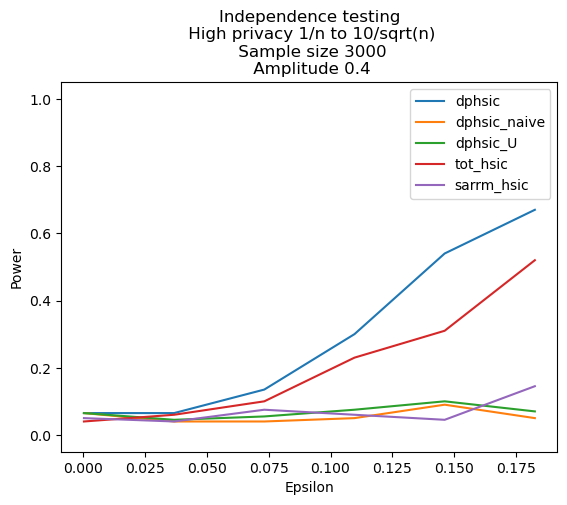

In [84]:
# load results
power = jnp.load("results/uniform_hsic_power_vary_privacy_high.npy")
x_axis = jnp.load("results/uniform_hsic_power_vary_privacy_high_x_axis.npy")
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Epsilon')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Independence testing' 
    '\n High privacy 1/n to 10/sqrt(n)'
    '\n Sample size 3000'
    '\n Amplitude 0.4'
)

### Power: Vary privacy (mid privacy regime)

In [ ]:
# parameters
repetitions = 200
m = n = 3000
epsilons = jnp.linspace(10 / jnp.sqrt(n), 1, 6)
num_perturbations = 1
dX = 1
dY = 1
scale = 0.2
tests = (dphsic, dphsic_naive, dphsic_U_lower, tot__hsic, sarrm__hsic)
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# run experiment
key = random.PRNGKey(42)
key, subkey = random.split(key)
X_all, Y_all = sampler_perturb_IndT(
    key=subkey,
    m=m,
    dX=dX,
    dY=dY,
    num_random=repetitions,
    num_perturbations=num_perturbations,
    scale=scale,
)
outputs = jnp.zeros((len(tests), len(epsilons), repetitions))
for i in range(repetitions):
    X = X_all[i] * 4
    Y = Y_all[i] * 4
    for s in range(len(epsilons)):
        epsilon = epsilons[s]
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_hsic_power_vary_privacy_mid.npy", power)
jnp.save("results/uniform_hsic_power_vary_privacy_mid_x_axis.npy", epsilons)

dphsic 
 [0.19       0.405      0.655      0.79999995 0.875      0.935     ] 

dphsic_naive 
 [0.065 0.035 0.04  0.035 0.05  0.06 ] 

dphsic_U 
 [0.07  0.045 0.05  0.045 0.075 0.09 ] 

tot_hsic 
 [0.09999999 0.17999999 0.22       0.265      0.275      0.26999998] 

sarrm_hsic 
 [0.05       0.05       0.185      0.13499999 0.17999999 0.39999998] 



Text(0.5, 1.0, 'Independence testing\n Mid privacy 10/sqrt(n) to 1\n Sample size 3000\n Amplitude 0.2')

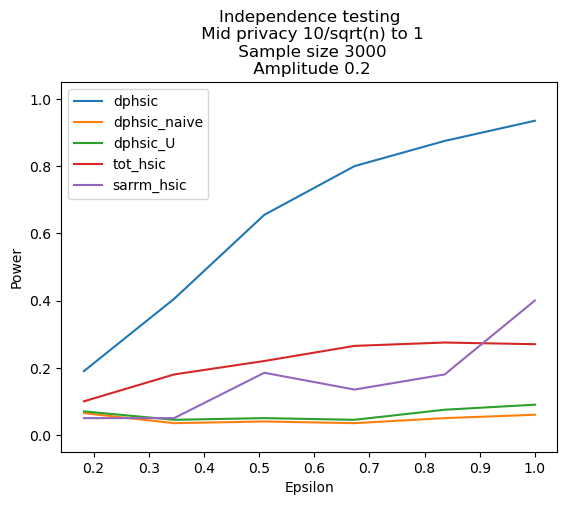

In [87]:
# load results
power = jnp.load("results/uniform_hsic_power_vary_privacy_mid.npy")
x_axis = jnp.load("results/uniform_hsic_power_vary_privacy_mid_x_axis.npy")
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Epsilon')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Independence testing' 
    '\n Mid privacy 10/sqrt(n) to 1'
    '\n Sample size 3000'
    '\n Amplitude 0.2'
)

### Power: Vary privacy (low privacy regime)

In [ ]:
# parameters
repetitions = 200
m = n = 3000
epsilons = jnp.linspace(1, jnp.sqrt(n), 6)
num_perturbations = 1
dX = 1
dY = 1
scale = 0.15
tests = (dphsic, dphsic_naive, dphsic_U_lower, tot__hsic, sarrm__hsic)
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# run experiment
key = random.PRNGKey(42)
key, subkey = random.split(key)
X_all, Y_all = sampler_perturb_IndT(
    key=subkey,
    m=m,
    dX=dX,
    dY=dY,
    num_random=repetitions,
    num_perturbations=num_perturbations,
    scale=scale,
)
outputs = jnp.zeros((len(tests), len(epsilons), repetitions))
for i in range(repetitions):
    X = X_all[i] * 4
    Y = Y_all[i] * 4 
    for s in range(len(epsilons)):
        epsilon = epsilons[s]
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_hsic_power_vary_privacy_low.npy", power)
jnp.save("results/uniform_hsic_power_vary_privacy_low_x_axis.npy", epsilons)

dphsic 
 [0.72499996 0.84999996 0.85499996 0.84999996 0.84999996 0.84999996] 

dphsic_naive 
 [0.065 0.035 0.045 0.035 0.06  0.065] 

dphsic_U 
 [0.085      0.585      0.78       0.815      0.835      0.85499996] 

tot_hsic 
 [0.17999999 0.17999999 0.175      0.17999999 0.17       0.17999999] 

sarrm_hsic 
 [0.21       0.53       0.525      0.525      0.525      0.53499997] 



Text(0.5, 1.0, 'Independence testing\n Low privacy 1 to sqrt(n)\n Sample size 3000\n Amplitude 0.15')

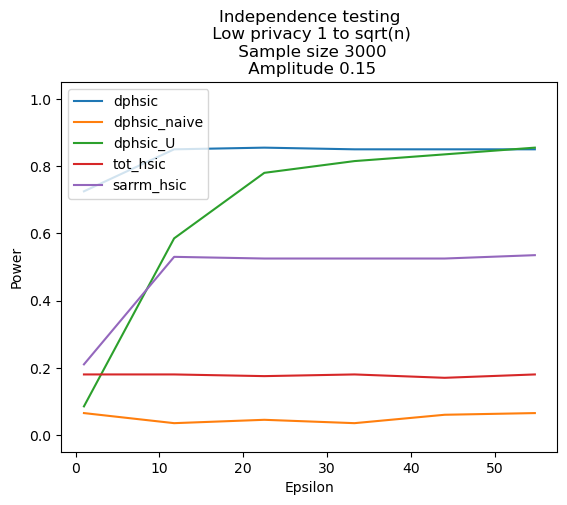

In [97]:
# load results
power = jnp.load("results/uniform_hsic_power_vary_privacy_low.npy")
x_axis = jnp.load("results/uniform_hsic_power_vary_privacy_low_x_axis.npy")
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Epsilon')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Independence testing' 
    '\n Low privacy 1 to sqrt(n)'
    '\n Sample size 3000'
    '\n Amplitude 0.15'
)

### Power Appendix: Vary privacy

In [ ]:
# parameters
repetitions = 200
m = n = 5000
epsilons = jnp.linspace(1, jnp.sqrt(n), 6)
num_perturbations = 1
dX = 1
dY = 1
scale = 1
tests = (dphsic, dphsic_naive, dphsic_U_lower, tot__hsic, sarrm__hsic)
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# run experiment
key = random.PRNGKey(42)
key, subkey = random.split(key)
X_all, Y_all = sampler_perturb_IndT(
    key=subkey,
    m=m,
    dX=dX,
    dY=dY,
    num_random=repetitions,
    num_perturbations=num_perturbations,
    scale=scale,
)
outputs = jnp.zeros((len(tests), len(epsilons), repetitions))
for i in range(repetitions):
    X = X_all[i] * 4
    Y = Y_all[i] * 4 
    for s in range(len(epsilons)):
        epsilon = epsilons[s]
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_hsic_power_vary_privacy_appendix.npy", power)
jnp.save("results/uniform_hsic_power_vary_privacy_appendix_x_axis.npy", epsilons)

dphsic 
 [1. 1. 1. 1. 1. 1.] 

dphsic_naive 
 [0.07       0.12       0.445      0.79999995 0.945      0.98499995] 

dphsic_U 
 [1. 1. 1. 1. 1. 1.] 

tot_hsic 
 [1. 1. 1. 1. 1. 1.] 

sarrm_hsic 
 [0.965 1.    1.    1.    1.    1.   ] 



Text(0.5, 1.0, 'Independence testing\n Low privacy 1 to sqrt(n)\n Sample size 5000\n Amplitude 1')

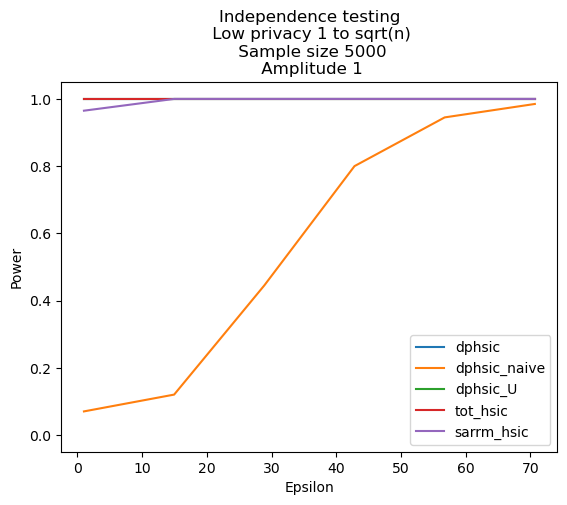

In [138]:
# load results
power = jnp.load("results/uniform_hsic_power_vary_privacy_appendix.npy")
x_axis = jnp.load("results/uniform_hsic_power_vary_privacy_appendix_x_axis.npy")
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Epsilon')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Independence testing' 
    '\n Low privacy 1 to sqrt(n)'
    '\n Sample size 5000'
    '\n Amplitude 1'
)

### Level: Vary privacy

In [ ]:
# parameters
repetitions = 200
m = n = 3000
epsilons = jnp.linspace(1 / jnp.sqrt(n), jnp.sqrt(n), 6)
num_perturbations = 1
dX = 1
dY = 1
scale = 0
tests = (dphsic, dphsic_naive, dphsic_U_lower, tot__hsic, sarrm__hsic)
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# run experiment
key = random.PRNGKey(42)
key, subkey = random.split(key)
X_all, Y_all = sampler_perturb_IndT(
    key=subkey,
    m=m,
    dX=dX,
    dY=dY,
    num_random=repetitions,
    num_perturbations=num_perturbations,
    scale=scale,
)
outputs = jnp.zeros((len(tests), len(epsilons), repetitions))
for i in range(repetitions):
    X = X_all[i] * 4
    Y = Y_all[i] * 4 
    for s in range(len(epsilons)):
        epsilon = epsilons[s]
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_hsic_level_vary_privacy.npy", power)
jnp.save("results/uniform_hsic_level_vary_privacy_x_axis.npy", epsilons)

dphsic 
 [0.065 0.05  0.05  0.06  0.06  0.06 ] 

dphsic_naive 
 [0.065 0.035 0.04  0.035 0.05  0.055] 

dphsic_U 
 [0.065 0.03  0.055 0.06  0.055 0.05 ] 

tot_hsic 
 [0.05  0.06  0.05  0.06  0.06  0.065] 

sarrm_hsic 
 [0.075 0.065 0.06  0.065 0.055 0.055] 



Text(0.5, 1.0, 'Independence testing\n Privacy 1/sqrt(n) to sqrt(n)\n Sample size 3000')

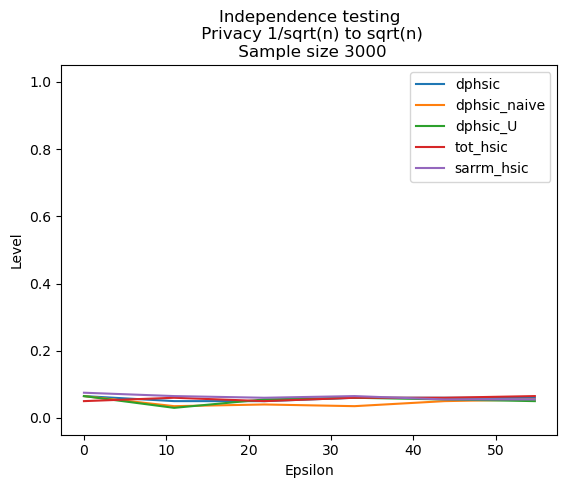

In [122]:
# load results
power = jnp.load("results/uniform_hsic_level_vary_privacy.npy")
x_axis = jnp.load("results/uniform_hsic_level_vary_privacy_x_axis.npy")
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Epsilon')
plt.ylabel('Level')
plt.ylim(-0.05, 1.05)
plt.title(
    'Independence testing' 
    '\n Privacy 1/sqrt(n) to sqrt(n)'
    '\n Sample size 3000'
)

## Vary sample size

### Power: Vary sample size (high privacy)

In [ ]:
# parameters
repetitions = 200
sample_sizes = (1000, 2000, 3000, 4000, 5000)
num_perturbations = 1
dX = 1
dY = 1
scale = 0.4
tests = (dphsic, dphsic_naive, dphsic_U_lower, tot__hsic, sarrm__hsic)
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# run experiment
key = random.PRNGKey(43)
outputs = jnp.zeros((len(tests), len(sample_sizes), repetitions))
for s in range(len(sample_sizes)):
    m = n = sample_sizes[s]
    epsilon = 10 / jnp.sqrt(n)
    key, subkey = random.split(key)
    X_all, Y_all = sampler_perturb_IndT(
        key=subkey,
        m=m,
        dX=dX,
        dY=dY,
        num_random=repetitions,
        num_perturbations=num_perturbations,
        scale=scale,
    )
    for i in range(repetitions):
        X = X_all[i] * 4
        Y = Y_all[i] * 4
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_hsic_power_vary_n_high.npy", power)
jnp.save("results/uniform_hsic_power_vary_n_high_x_axis.npy", sample_sizes)

dphsic 
 [0.22       0.405      0.72499996 0.835      0.89      ] 

dphsic_naive 
 [0.02  0.03  0.04  0.045 0.06 ] 

dphsic_U 
 [0.035 0.03  0.07  0.065 0.09 ] 

tot_hsic 
 [0.22  0.265 0.445 0.53  0.65 ] 

sarrm_hsic 
 [0.045      0.06       0.11499999 0.095      0.11      ] 



Text(0.5, 1.0, 'Independence testing\n High privacy 10/sqrt(n)\n Amplitude 0.4')

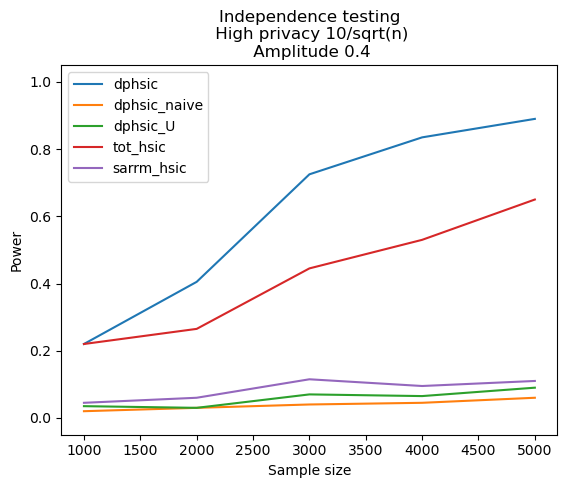

In [102]:
# load results
power = jnp.load("results/uniform_hsic_power_vary_n_high.npy")
x_axis = jnp.load("results/uniform_hsic_power_vary_n_high_x_axis.npy")
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Sample size')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Independence testing' 
    '\n High privacy 10/sqrt(n)' 
    '\n Amplitude 0.4'
)

### Power: Vary sample size (mid privacy)

In [ ]:
# parameters
repetitions = 200
sample_sizes = (1000, 2000, 3000, 4000, 5000)
num_perturbations = 1
dX = 1
dY = 1
scale = 0.2
tests = (dphsic, dphsic_naive, dphsic_U_lower, tot__hsic, sarrm__hsic)
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# run experiment
key = random.PRNGKey(43)
outputs = jnp.zeros((len(tests), len(sample_sizes), repetitions))
for s in range(len(sample_sizes)):
    m = n = sample_sizes[s]
    epsilon = 1
    key, subkey = random.split(key)
    X_all, Y_all = sampler_perturb_IndT(
        key=subkey,
        m=m,
        dX=dX,
        dY=dY,
        num_random=repetitions,
        num_perturbations=num_perturbations,
        scale=scale,
    )
    for i in range(repetitions):
        X = X_all[i] * 4
        Y = Y_all[i] * 4
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_hsic_power_vary_n_mid.npy", power)
jnp.save("results/uniform_hsic_power_vary_n_mid_x_axis.npy", sample_sizes)

dphsic 
 [0.265      0.71999997 0.94       0.98999995 0.995     ] 

dphsic_naive 
 [0.02  0.03  0.04  0.045 0.06 ] 

dphsic_U 
 [0.03       0.035      0.085      0.09999999 0.145     ] 

tot_hsic 
 [0.14       0.14999999 0.24499999 0.33499998 0.48999998] 

sarrm_hsic 
 [0.12  0.21  0.41  0.52  0.615] 



Text(0.5, 1.0, 'Independence testing\n Mid privacy 1\n Amplitude 0.2')

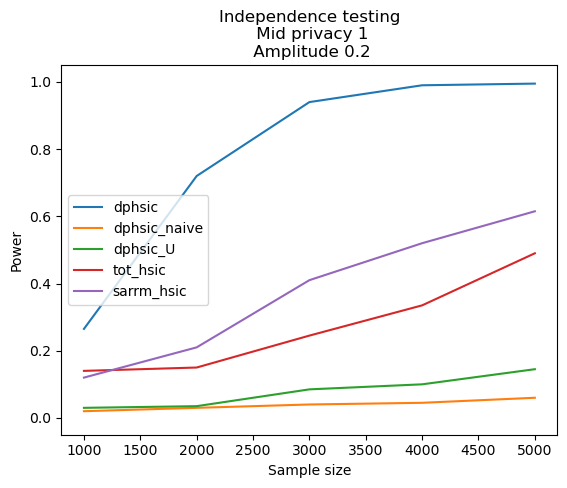

In [106]:
# load results
power = jnp.load("results/uniform_hsic_power_vary_n_mid.npy")
x_axis = jnp.load("results/uniform_hsic_power_vary_n_mid_x_axis.npy")
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Sample size')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Independence testing' 
    '\n Mid privacy 1'
    '\n Amplitude 0.2'
)

### Power: Vary sample size (low privacy)

In [ ]:
# parameters
repetitions = 200
sample_sizes = (1000, 2000, 3000, 4000, 5000)
num_perturbations = 1
dX = 1
dY = 1
scale = 0.1
tests = (dphsic, dphsic_naive, dphsic_U_lower, tot__hsic, sarrm__hsic)
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# run experiment
key = random.PRNGKey(43)
outputs = jnp.zeros((len(tests), len(sample_sizes), repetitions))
for s in range(len(sample_sizes)):
    m = n = sample_sizes[s]
    epsilon = jnp.sqrt(n) / 10
    key, subkey = random.split(key)
    X_all, Y_all = sampler_perturb_IndT(
        key=subkey,
        m=m,
        dX=dX,
        dY=dY,
        num_random=repetitions,
        num_perturbations=num_perturbations,
        scale=scale,
    )
    for i in range(repetitions):
        X = X_all[i] * 4
        Y = Y_all[i] * 4
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_hsic_power_vary_n_low.npy", power)
jnp.save("results/uniform_hsic_power_vary_n_low_x_axis.npy", sample_sizes)

dphsic 
 [0.155      0.39999998 0.525      0.715      0.835     ] 

dphsic_naive 
 [0.02  0.03  0.04  0.045 0.065] 

dphsic_U 
 [0.035      0.05       0.11499999 0.17999999 0.345     ] 

tot_hsic 
 [0.08 0.07 0.09 0.11 0.13] 

sarrm_hsic 
 [0.05       0.14999999 0.205      0.29       0.42499998] 



Text(0.5, 1.0, 'Independence testing\n Low privacy sqrt(n)/10\n Amplitude 0.1')

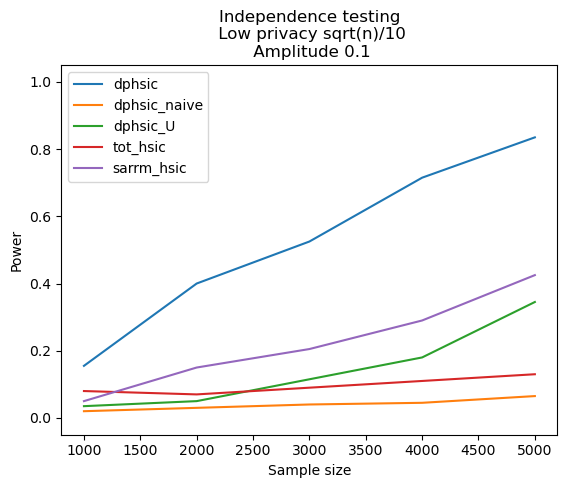

In [108]:
# load results
power = jnp.load("results/uniform_hsic_power_vary_n_low.npy")
x_axis = jnp.load("results/uniform_hsic_power_vary_n_low_x_axis.npy")
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Sample size')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Independence testing'
    '\n Low privacy sqrt(n)/10' 
    '\n Amplitude 0.1'
)

### Power Appendix: Vary sample size

In [ ]:
# parameters
repetitions = 200
sample_sizes = (1000, 2000, 3000, 4000, 5000)
num_perturbations = 1
dX = 1
dY = 1
scale = 1
tests = (dphsic, dphsic_naive, dphsic_U_lower, tot__hsic, sarrm__hsic)
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# run experiment
key = random.PRNGKey(43)
outputs = jnp.zeros((len(tests), len(sample_sizes), repetitions))
for s in range(len(sample_sizes)):
    m = n = sample_sizes[s]
    epsilon = jnp.sqrt(n)
    key, subkey = random.split(key)
    X_all, Y_all = sampler_perturb_IndT(
        key=subkey,
        m=m,
        dX=dX,
        dY=dY,
        num_random=repetitions,
        num_perturbations=num_perturbations,
        scale=scale,
    )
    for i in range(repetitions):
        X = X_all[i] * 4
        Y = Y_all[i] * 4
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_hsic_power_vary_n_appendix.npy", power)
jnp.save("results/uniform_hsic_power_vary_n_appendix_x_axis.npy", sample_sizes)

dphsic 
 [1. 1. 1. 1. 1.] 

dphsic_naive 
 [0.05       0.125      0.62       0.9        0.98499995] 

dphsic_U 
 [1. 1. 1. 1. 1.] 

tot_hsic 
 [1. 1. 1. 1. 1.] 

sarrm_hsic 
 [1. 1. 1. 1. 1.] 



Text(0.5, 1.0, 'Independence testing\n Low privacy sqrt(n)')

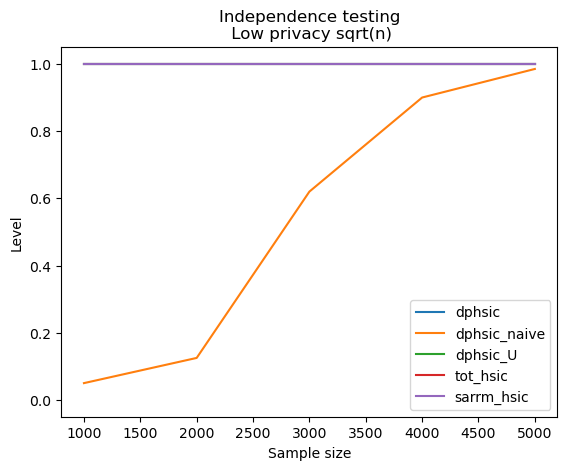

In [148]:
# load results
power = jnp.load("results/uniform_hsic_power_vary_n_appendix.npy")
x_axis = jnp.load("results/uniform_hsic_power_vary_n_appendix_x_axis.npy")
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Sample size')
plt.ylabel('Level')
plt.ylim(-0.05, 1.05)
plt.title(
    'Independence testing'
    '\n Low privacy sqrt(n)'     
)

### Level: Vary sample size

In [ ]:
# parameters
repetitions = 200
sample_sizes = (1000, 2000, 3000, 4000, 5000)
num_perturbations = 1
dX = 1
dY = 1
scale = 0
tests = (dphsic, dphsic_naive, dphsic_U_lower, tot__hsic, sarrm__hsic)
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# run experiment
key = random.PRNGKey(43)
outputs = jnp.zeros((len(tests), len(sample_sizes), repetitions))
for s in range(len(sample_sizes)):
    m = n = sample_sizes[s]
    epsilon = 10 / jnp.sqrt(n)
    key, subkey = random.split(key)
    X_all, Y_all = sampler_perturb_IndT(
        key=subkey,
        m=m,
        dX=dX,
        dY=dY,
        num_random=repetitions,
        num_perturbations=num_perturbations,
        scale=scale,
    )
    for i in range(repetitions):
        X = X_all[i] * 4
        Y = Y_all[i] * 4
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_hsic_level_vary_n.npy", power)
jnp.save("results/uniform_hsic_level_vary_n_x_axis.npy", sample_sizes)

dphsic 
 [0.035 0.025 0.05  0.035 0.055] 

dphsic_naive 
 [0.02  0.03  0.04  0.045 0.06 ] 

dphsic_U 
 [0.02  0.03  0.04  0.045 0.06 ] 

tot_hsic 
 [0.055 0.06  0.05  0.045 0.025] 

sarrm_hsic 
 [0.06  0.085 0.025 0.03  0.055] 



Text(0.5, 1.0, 'Independence testing\n High privacy 10 / sqrt(n)')

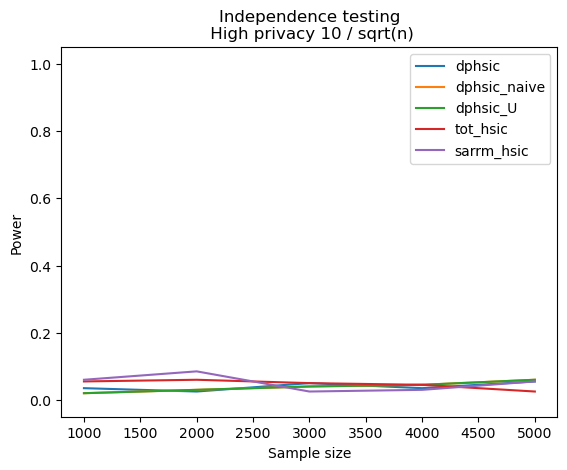

In [126]:
# load results
power = jnp.load("results/uniform_hsic_level_vary_n.npy")
x_axis = jnp.load("results/uniform_hsic_level_vary_n_x_axis.npy")
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Sample size')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Independence testing'
    '\n High privacy 10 / sqrt(n)' 
)

## Vary dimension

### Power: Vary dimension (high privacy)

In [ ]:
# parameters
repetitions = 200
m = n = 3000
dimensions = (1, 3, 5, 7, 9)
epsilon = 10 / jnp.sqrt(n)
num_perturbations = 1
scale = 0.4
tests = (dphsic, dphsic_naive, dphsic_U_lower, tot__hsic, sarrm__hsic)
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# run experiment
key = random.PRNGKey(44)
outputs = jnp.zeros((len(tests), len(dimensions), repetitions))
for s in range(len(dimensions)):
    dX = dimensions[s]
    dY = dimensions[s]
    key, subkey = random.split(key)
    X_all, Y_all = sampler_perturb_IndT(
        key=subkey,
        m=m,
        dX=dX,
        dY=dY,
        num_random=repetitions,
        num_perturbations=num_perturbations,
        scale=scale,
    )
    for i in range(repetitions):
        X = X_all[i] * 3
        Y = Y_all[i] * 3
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_hsic_power_vary_d_high.npy", power)
jnp.save("results/uniform_hsic_power_vary_d_high_x_axis.npy", dimensions)

dphsic 
 [0.66999996 0.095      0.06       0.075      0.07      ] 

dphsic_naive 
 [0.05  0.045 0.05  0.065 0.06 ] 

dphsic_U 
 [0.07  0.045 0.05  0.065 0.06 ] 

tot_hsic 
 [0.45999998 0.075      0.05       0.055      0.06      ] 

sarrm_hsic 
 [0.145 0.045 0.04  0.07  0.055] 



Text(0.5, 1.0, 'Independence testing\n High privacy 10/sqrt(n)\n Sample size 3000\n Amplitude 0.4')

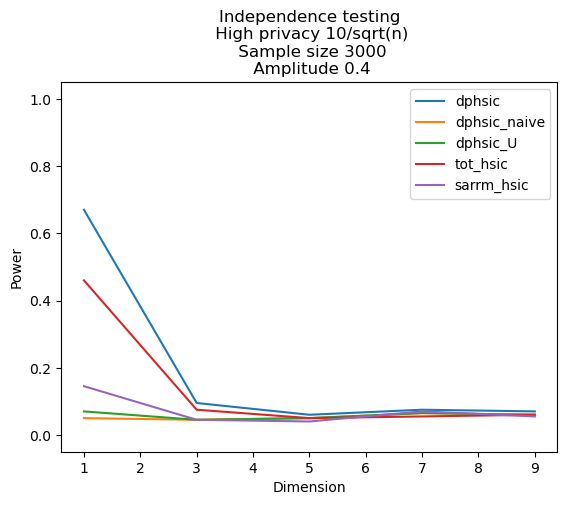

In [114]:
# load results
power = jnp.load("results/uniform_hsic_power_vary_d_high.npy")
x_axis = jnp.load("results/uniform_hsic_power_vary_d_high_x_axis.npy")
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Dimension')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Independence testing'
    '\n High privacy 10/sqrt(n)'
    '\n Sample size 3000'
    '\n Amplitude 0.4'
)

### Power: Vary dimension (mid privacy)

In [ ]:
# parameters
repetitions = 200
m = n = 3000
dimensions = (1, 3, 5, 7, 9)
epsilon = 1
num_perturbations = 1
scale = 0.35
tests = (dphsic, dphsic_naive, dphsic_U_lower, tot__hsic, sarrm__hsic)
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# run experiment
key = random.PRNGKey(44)
outputs = jnp.zeros((len(tests), len(dimensions), repetitions))
for s in range(len(dimensions)):
    dX = dimensions[s]
    dY = dimensions[s]
    key, subkey = random.split(key)
    X_all, Y_all = sampler_perturb_IndT(
        key=subkey,
        m=m,
        dX=dX,
        dY=dY,
        num_random=repetitions,
        num_perturbations=num_perturbations,
        scale=scale,
    )
    for i in range(repetitions):
        X = X_all[i] * 3
        Y = Y_all[i] * 3
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_hsic_power_vary_d_mid.npy", power)
jnp.save("results/uniform_hsic_power_vary_d_mid_x_axis.npy", dimensions)

dphsic 
 [1.         0.53499997 0.13499999 0.095      0.085     ] 

dphsic_naive 
 [0.05  0.045 0.05  0.065 0.06 ] 

dphsic_U 
 [0.155 0.06  0.05  0.075 0.065] 

tot_hsic 
 [0.875      0.175      0.085      0.11499999 0.035     ] 

sarrm_hsic 
 [0.875 0.275 0.09  0.08  0.06 ] 



Text(0.5, 1.0, 'Independence testing\n Mid privacy 1\n Sample size 3000\n Amplitude 0.35')

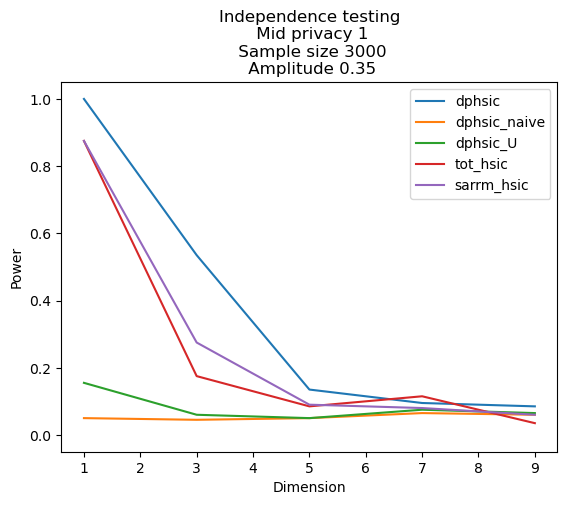

In [117]:
# load results
power = jnp.load("results/uniform_hsic_power_vary_d_mid.npy")
x_axis = jnp.load("results/uniform_hsic_power_vary_d_mid_x_axis.npy")
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Dimension')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Independence testing'
    '\n Mid privacy 1'
    '\n Sample size 3000'
    '\n Amplitude 0.35'
)

### Power: Vary dimension (low privacy)

In [ ]:
# parameters
repetitions = 200
m = n = 3000
dimensions = (1, 3, 5, 7, 9)
epsilon = jnp.sqrt(n) / 10
num_perturbations = 1
scale = 0.3
tests = (dphsic, dphsic_naive, dphsic_U_lower, tot__hsic, sarrm__hsic)
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# run experiment
key = random.PRNGKey(44)
outputs = jnp.zeros((len(tests), len(dimensions), repetitions))
for s in range(len(dimensions)):
    dX = dimensions[s]
    dY = dimensions[s]
    key, subkey = random.split(key)
    X_all, Y_all = sampler_perturb_IndT(
        key=subkey,
        m=m,
        dX=dX,
        dY=dY,
        num_random=repetitions,
        num_perturbations=num_perturbations,
        scale=scale,
    )
    for i in range(repetitions):
        X = X_all[i] * 3
        Y = Y_all[i] * 3
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_hsic_power_vary_d_low.npy", power)
jnp.save("results/uniform_hsic_power_vary_d_low_x_axis.npy", dimensions)

dphsic 
 [1.    0.945 0.56  0.24  0.145] 

dphsic_naive 
 [0.05  0.045 0.05  0.065 0.06 ] 

dphsic_U 
 [0.98499995 0.105      0.06       0.075      0.07      ] 

tot_hsic 
 [0.74  0.155 0.11  0.125 0.06 ] 

sarrm_hsic 
 [0.995      0.64       0.325      0.21       0.09999999] 



Text(0.5, 1.0, 'Independence testing\n Low privacy sqrt(n)/10\n Sample size 3000\n Amplitude 0.3')

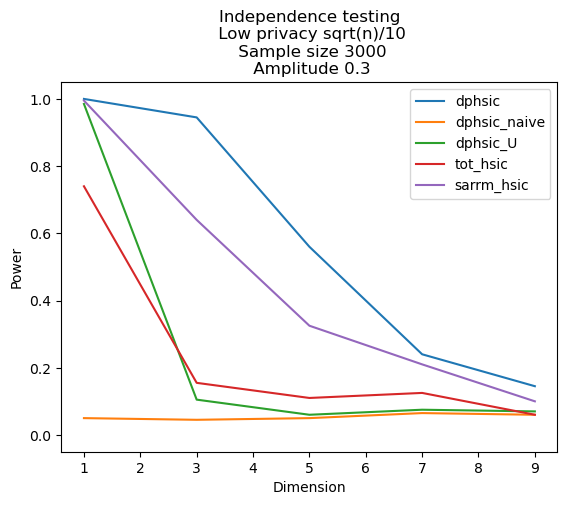

In [119]:
# load results
power = jnp.load("results/uniform_hsic_power_vary_d_low.npy")
x_axis = jnp.load("results/uniform_hsic_power_vary_d_low_x_axis.npy")
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Dimension')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Independence testing'
    '\n Low privacy sqrt(n)/10'
    '\n Sample size 3000'
    '\n Amplitude 0.3'
)

### Power Appendix: Vary dimension

In [ ]:
# parameters
repetitions = 200
m = n = 5000
dimensions = (1, 3, 5, 7, 9)
epsilon = jnp.sqrt(n)
num_perturbations = 1
scale = 1
tests = (dphsic, dphsic_naive, dphsic_U_lower, tot__hsic, sarrm__hsic)
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# run experiment
key = random.PRNGKey(44)
outputs = jnp.zeros((len(tests), len(dimensions), repetitions))
for s in range(len(dimensions)):
    dX = dimensions[s]
    dY = dimensions[s]
    key, subkey = random.split(key)
    X_all, Y_all = sampler_perturb_IndT(
        key=subkey,
        m=m,
        dX=dX,
        dY=dY,
        num_random=repetitions,
        num_perturbations=num_perturbations,
        scale=scale,
    )
    for i in range(repetitions):
        X = X_all[i] * 3
        Y = Y_all[i] * 3
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_hsic_power_vary_d_appendix.npy", power)
jnp.save("results/uniform_hsic_power_vary_d_appendix_x_axis.npy", dimensions)

dphsic 
 [1. 1. 1. 1. 1.] 

dphsic_naive 
 [0.97999996 0.19       0.11499999 0.095      0.095     ] 

dphsic_U 
 [1. 1. 1. 1. 1.] 

tot_hsic 
 [1.    1.    1.    0.955 0.825] 

sarrm_hsic 
 [1. 1. 1. 1. 1.] 



Text(0.5, 1.0, 'Independence testing\n Low privacy sqrt(n)\n Sample size 5000\n Amplitude 1')

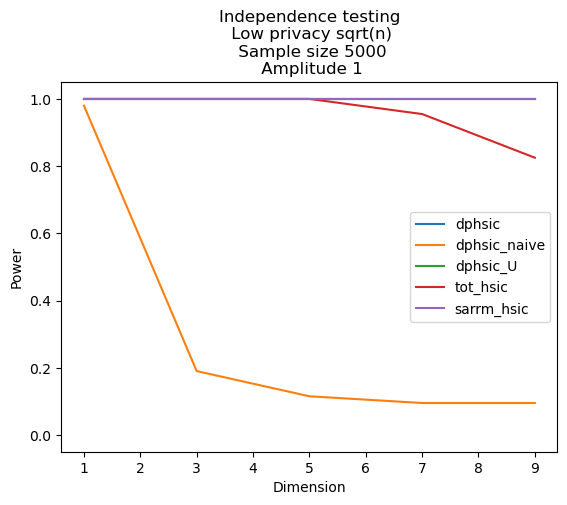

In [13]:
# load results
power = jnp.load("results/uniform_hsic_power_vary_d_appendix.npy")
x_axis = jnp.load("results/uniform_hsic_power_vary_d_appendix_x_axis.npy")
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Dimension')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title(
    'Independence testing'
    '\n Low privacy sqrt(n)'
    '\n Sample size 5000'
    '\n Amplitude 1'
)

### Level: Vary dimension

In [ ]:
# parameters
repetitions = 200
m = n = 3000
epsilon = jnp.sqrt(n) / 10
dimensions = (1, 50, 100, 150, 200)
num_perturbations = 1
scale = 0
tests = (dphsic, dphsic_naive, dphsic_U_lower, tot__hsic, sarrm__hsic)
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# run experiment
key = random.PRNGKey(44)
outputs = jnp.zeros((len(tests), len(dimensions), repetitions))
for s in range(len(dimensions)):
    dX = dimensions[s]
    dY = dimensions[s]
    key, subkey = random.split(key)
    X_all, Y_all = sampler_perturb_IndT(
        key=subkey,
        m=m,
        dX=dX,
        dY=dY,
        num_random=repetitions,
        num_perturbations=num_perturbations,
        scale=scale,
    )
    for i in range(repetitions):
        X = X_all[i] * 3
        Y = Y_all[i] * 3
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t, s, i] = test(
                subkey,
                X,
                Y,
                epsilon,
            )

# save results
power = jnp.mean(outputs, -1)
jnp.save("results/uniform_hsic_level_vary_d.npy", power)
jnp.save("results/uniform_hsic_level_vary_d_x_axis.npy", dimensions)

dphsic 
 [0.055 0.045 0.05  0.065 0.06 ] 

dphsic_naive 
 [0.05  0.045 0.05  0.065 0.06 ] 

dphsic_U 
 [0.05  0.045 0.05  0.065 0.06 ] 

tot_hsic 
 [0.055 0.05  0.06  0.07  0.04 ] 

sarrm_hsic 
 [0.07  0.055 0.06  0.03  0.025] 



Text(0.5, 1.0, 'Independence testing\n Low privacy sqrt(n)/10\n Sample size 3000')

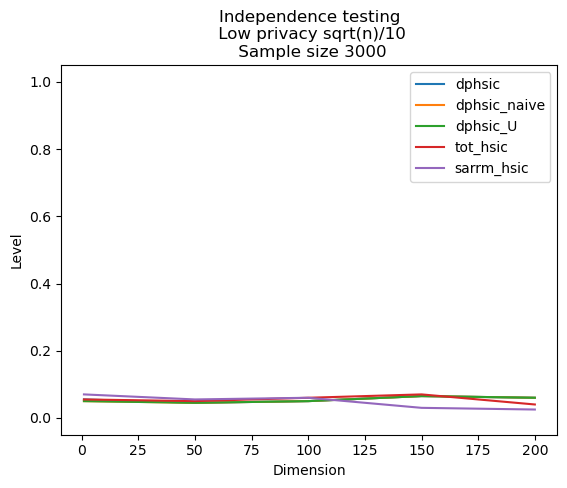

In [128]:
# load results
power = jnp.load("results/uniform_hsic_level_vary_d.npy")
x_axis = jnp.load("results/uniform_hsic_level_vary_d_x_axis.npy")
tests_labels = ('dphsic', 'dphsic_naive', 'dphsic_U', 'tot_hsic', 'sarrm_hsic')

# plot
for t in range(len(tests_labels)):
    print(tests_labels[t], '\n', power[t], '\n')
    plt.plot(x_axis[power[t] >= 0], power[t][power[t] >= 0], label=tests_labels[t])
plt.legend()
plt.xlabel('Dimension')
plt.ylabel('Level')
plt.ylim(-0.05, 1.05)
plt.title(
    'Independence testing'
    '\n Low privacy sqrt(n)/10'
    '\n Sample size 3000'
)